# O$_{2}$-TPD数据处理

## 1-导入数据

import numpy和matplotlib导入已经预处理的O2-TPD.csv文件

In [1]:
# -*- coding: utf-8 -*-
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import linalg
from scipy import integrate
from scipy.optimize import fminbound
import pandas as pd

data = np.genfromtxt("O2TPD.csv", delimiter=",", encoding='UTF-8')  # 打开Excel文件

自然而然的好奇data是什么数据格式

In [2]:
#非主干
print(f"数据格式为{type(data)}；\n把data直接输出得到结果如下：\n{data}；\n测量其长度{len(data)}")

数据格式为<class 'numpy.ndarray'>；
把data直接输出得到结果如下：
[[4.9967400e+01 0.0000000e+00 5.0125280e+01 3.0000000e-02]
 [4.9972890e+01 8.5800000e-05 5.0133160e+01 3.0040000e-02]
 [4.9973990e+01 1.9100000e-05 5.0118840e+01 3.0010000e-02]
 ...
 [8.9744904e+02 3.4800000e-03 8.9771985e+02 3.4140000e-02]
 [8.9762299e+02 3.3700000e-03 8.9789160e+02 3.4100000e-02]
 [8.9777454e+02 3.4000000e-03 8.9805237e+02 3.4140000e-02]]；
测量其长度6317


所以是n维数组（4维），长度为6317

## 2-作图

导入每列数据，用numpy向量存储

In [3]:
T_110 = data[0:, 0]  # 第1列，所有行数据（110温度）
S_110 = data[0:, 1]  # 第2列，所有行数据（110信号）
T_310 = data[0:, 2]
S_310 = data[0:, 3]

In [4]:
#非主干
print(type(T_110))   #看一下存储为什么数据类型
print(T_110[0::1000])  #每1000个数据取出一个输出看看
print(T_110[np.argmax(T_110)]) #找到数组最大值

<class 'numpy.ndarray'>
[ 49.9674   49.95971 171.32346 339.17923 507.09882 675.32294 844.6936 ]
897.77454


作图

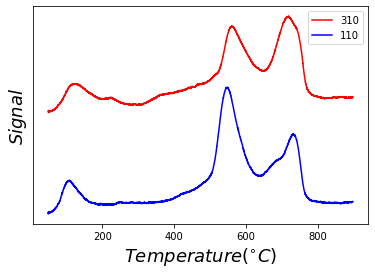

In [5]:
fig, ax = plt.subplots()
ax.plot(T_310, S_310, color="red", label="310")
ax.plot(T_110, S_110, color="blue", label="110")

# 坐标轴标注
ax.set_ylabel(r"$Signal$", fontsize=18)
ax.set_xlabel(r"$Temperature(^{\circ}C)$", fontsize=18)
ax.legend()  

# 隐藏y轴的刻度值
ax.set_yticks([])
ax.yaxis.set_ticks_position('none')  

fig.savefig("O2-TPD.jpg")

## 3-处理数据

### 3-1 首先进行插值，使散点图变成函数

在使用全部数据进行插值前，先使用110的前几个点来复习一下数值分析的课程  
在定义X和Y是为了方便修改参数，来了解scipy.interpolate.interp1d，比如当选择（1200：20）时报错：  
ValueError: Expect x to not have duplicates(但是一阶和零阶不会报错)，意味一个x对应了两个y值；   
可以看见最后有明显的龙格现象。

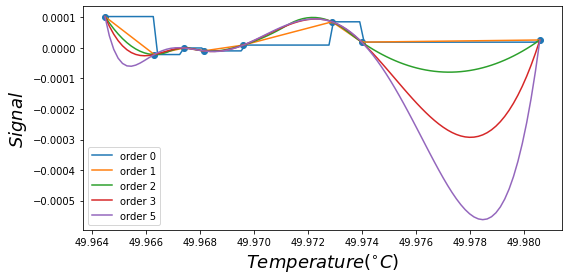

In [6]:
#非主干
S = 0
X = 8
Y = 1
NT_110 = data[S:X:Y, 0]  # 第1列，前X行数据每隔着Y个选一个温度（110温度）
NS_110 = data[S:X:Y, 1]  # 第2列，温度对应下的型号强度（110信号）
xx = np.linspace(NT_110.min(), NT_110.max(), 100)

fig, ax = plt.subplots(figsize=(8, 4))

ax.scatter(NT_110, NS_110)

for n in (0, 1, 2, 3, 5):
    f = interpolate.interp1d(NT_110, NS_110, kind=n)
    ax.plot(xx, f(xx), label='order %d' % n)

ax.legend()
ax.set_ylabel(r"$Signal$", fontsize=18)
ax.set_xlabel(r"$Temperature(^{\circ}C)$", fontsize=18)

fig.tight_layout()
fig.savefig('Runge.jpg')

### 3-2 计算各区域积分

现在使用一次样条插值来积分各部分，第一部分为0到300度；第二部分为300到两峰谷，需要函数找到最小值  
这里用IS（积分310）来积分，因为之前作图的310有向上偏移。其实这样不严谨，下次注意

In [7]:
IS_310 = S_310 - 0.03

f110 = interpolate.interp1d(T_110, S_110, kind=1)
f310 = interpolate.interp1d(T_310, IS_310, kind=1)

#确定各区间限(一定要.copy不然全部一起走！！！！！！！！)
T_range = [50,300,850]
T110_range = T_range.copy()
T310_range = T_range.copy()

Tmin110 = fminbound(f110, 600, 700)
Tmin310 = fminbound(f310, 600, 700)

T110_range.append(Tmin110)
T110_range.sort()
T310_range.append(Tmin310)
T310_range.sort()

df = pd.DataFrame(columns=['110','310'])

for i in range(3):
    df.loc[i]=[integrate.quadrature(f110,T110_range[i],T110_range[i+1] )[0],integrate.quadrature(f310,T310_range[i],T310_range[i+1] )[0]]

d:\python\lib\site-packages\scipy\integrate\_quadrature.py:247: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.474900e-04
  AccuracyWarning)
d:\python\lib\site-packages\scipy\integrate\_quadrature.py:247: AccuracyWarning: maxiter (50) exceeded. Latest difference = 9.322704e-04
  AccuracyWarning)
d:\python\lib\site-packages\scipy\integrate\_quadrature.py:247: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.524433e-03
  AccuracyWarning)
d:\python\lib\site-packages\scipy\integrate\_quadrature.py:247: AccuracyWarning: maxiter (50) exceeded. Latest difference = 4.593662e-03
  AccuracyWarning)
d:\python\lib\site-packages\scipy\integrate\_quadrature.py:247: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.289921e-03
  AccuracyWarning)
d:\python\lib\site-packages\scipy\integrate\_quadrature.py:247: AccuracyWarning: maxiter (50) exceeded. Latest difference = 4.024497e-05
  AccuracyWarning)


In [8]:
df.index = ["吸附","表面","体相"]

In [9]:
df

,110,310
吸附,0.983287,0.972533
表面,4.085697,3.523047
体相,2.314428,2.776884


## 4-完善图

首先是从新找到草图

<class 'scipy.interpolate.interpolate.interp1d'>
110Maximum =  -0.009590000000000001
at x location  107.15191917951913
<class 'scipy.interpolate.interpolate.interp1d'>
310Maximum =  -0.007989999590998404
at x location  126.59121889480951


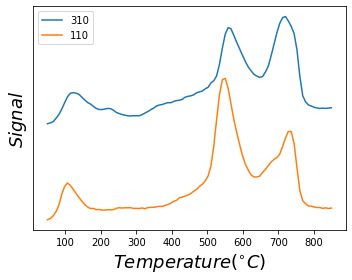

In [122]:
xx = np.linspace(50, 850, 100)

fig, ax = plt.subplots(figsize=(5, 4))

# #定义fmax找区域最大值
# def fmaxbound(func, x1, x2):
#     def f2(x):
#         return  -func
#     return fminbound(f2, x1, x2)

# T310m1 = fmaxbound(f310,50,200)
# T110m1 = fmaxbound(f110,50,200)
# print(T310m1,T110m1)

print(type(f110))
def negf110(x):
    return  -f110(x)
result = fminbound(negf110, 50,200)
print("110Maximum = ", negf110(result))
print("at x location ", result)

print(type(f310))
def negf310(x):
    return  -f310(x)
result = fminbound(negf310, 50,200)
print("310Maximum = ", negf310(result))
print("at x location ", result)


ax.plot(xx, f310(xx)+0.025, label='310')
ax.plot(xx, f110(xx), label='110')


ax.legend()
ax.set_ylabel(r"$Signal$", fontsize=18)
ax.set_xlabel(r"$Temperature(^{\circ}C)$", fontsize=18)

# 隐藏y轴的刻度值
ax.set_yticks([])
ax.yaxis.set_ticks_position('none') 


fig.tight_layout()
fig.savefig('O2-TPD_final.jpg')

## 5-附录

### 5-1 scipy peak教学：https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

peak并不能找到函数的极值，他只能找到数组的极值

In [ ]:
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
print(type(electrocardiogram()))
x = electrocardiogram()[0:4000]
print(type(x),x)
peaks, _ = find_peaks(x, height=0)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

### 5-2 scipy教学 
https://www.webpages.uidaho.edu/~mlowry/Teaching/Analysis&Design/build/html/mathematical_analysis.html

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from scipy import misc
from scipy import integrate
from scipy.optimize import fminbound

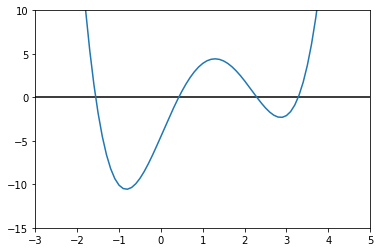

    fjac: array([[-1.]])
     fun: array([-3.55271368e-15])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-2.20458318e-09])
       r: array([33.28953419])
  status: 1
 success: True
       x: array([-1.55782277])


In [50]:
def f(x):
    return  0.9 * x**4 - 4 * x**3 + 0.5 * x**2 + 11 * x - 4.5
x = np.arange(-10, 10, 0.1)
y = []
for i in x:
    result = f(i)
    y.append(result)
plt.axhline(y=0, color='k')
plt.figure(1)
plt.plot(x, y)
plt.xlim(-3, 5)
plt.ylim(-15, 10)
plt.show()
# Example finding roots.
result = optimize.root(f, -2)
print(result)

In [51]:
def f2(x):
    return  -f(x)
result = optimize.minimize(f2, 1)
print("Maximum = ", -result.fun)
print("at x location ", result.x[0])

Maximum =  4.42769962882684
at x location  1.2940795902164146
